### Restricted Boltzman Machines (RBM)

RBM algorithm was proposed by Geoffrey Hinton (2007), which learns probability distribution over its sample training data inputs. It has seen wide applications in different areas of supervised/unsupervised machine learning such as feature learning, dimensionality reduction, classification, collaborative filtering, and topic modeling. 

Consider the example movie rating discussed in recommender system section. Movies like Avengers, Avatar, and Interstellar have strong associations with a latest fantasy and science fiction factor. Based on the user rating RBM will discover latent factors that can explain the activation of movie choices. In short RBM's describe variability among correlated variables of input dataset in terms of a potentially lower number of unobserved variables. 
The energy function is given by E(v, h) = - aTv – bTh – vTWh
The probability function of a visible input layer can be given by f(v)= -a^T v- ∑_i▒log ∑_(h_i)▒e^(h_i (b_i+ W_i v)) 

Let’s build a logistic regression model on digits dataset with BernoulliRBM and compare its accuracy with straight logistic regression (without BernoulliRBM) model’s accuracy.

In [1]:
# import the necessary packages
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from scipy.ndimage import convolve
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Manoh\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Manoh\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Let’s nudge the dataset set by moving the 8x8 images by 1 pixle on left, right, down and up to convolute the image. 

In [2]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((8, 8)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [3]:
# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, y = nudge_dataset(X, digits.target)

# Scale the features such that the values are between 0-1 scale
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)
print X.shape
print y.shape

(8985L, 64L)
(8985L,)


### Logistic Regression Grid Search

In [4]:
# perform a grid search on the 'C' parameter of Logistic
params = {"C": [1.0, 10.0, 100.0]}

gs = GridSearchCV(LogisticRegression(), params, n_jobs = -1, verbose = 1)
gs.fit(X_train, y_train)

# print diagnostic information to the user and grab the
print "Best Score: %0.3f" % (gs.best_score_)

# best model
bestParams = gs.best_estimator_.get_params()

print bestParams.items()

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    7.6s finished


Best Score: 0.774
[('warm_start', False), ('C', 100.0), ('n_jobs', 1), ('verbose', 0), ('intercept_scaling', 1), ('fit_intercept', True), ('max_iter', 100), ('penalty', 'l2'), ('multi_class', 'ovr'), ('random_state', None), ('dual', False), ('tol', 0.0001), ('solver', 'liblinear'), ('class_weight', None)]


In [5]:
# evaluate using Logistic Regression and only the raw pixel
logistic = LogisticRegression(C = 100)
logistic.fit(X_train, y_train)

print "Train accuracy: ", metrics.accuracy_score(y_train, logistic.predict(X_train))
print "Test accuracyL ", metrics.accuracy_score(y_test, logistic.predict(X_test))

Train accuracy:  0.796605453534
Test accuracyL  0.798553144129


### Grid search for RBM + Logistic Regression model

Perform a grid search on the learning rate, number of iterations, and number of components on the RBM and C for Logistic Regression

In [6]:
# initialize the RBM + Logistic Regression pipeline
rbm = BernoulliRBM()
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])

params = {
    "rbm__learning_rate": [0.1, 0.01, 0.001],
    "rbm__n_iter": [20, 40, 80],
    "rbm__n_components": [50, 100, 200],
    "logistic__C": [1.0, 10.0, 100.0]}

# perform a grid search over the parameter
gs = GridSearchCV(classifier, params, n_jobs = -1, verbose = 1)
gs.fit(X_train, y_train)

print "Best Score: %0.3f" % (gs.best_score_)

print "RBM + Logistic Regression parameters"
bestParams = gs.best_estimator_.get_params()

# loop over the parameters and print each of them out
# so they can be manually set
for p in sorted(params.keys()):
    print "\t %s: %f" % (p, bestParams[p])

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 15.1min finished


Best Score: 0.927
RBM + Logistic Regression parameters
	 logistic__C: 100.000000
	 rbm__learning_rate: 0.100000
	 rbm__n_components: 200.000000
	 rbm__n_iter: 20.000000


In [7]:
# initialize the RBM + Logistic Regression classifier with
# the cross-validated parameters
rbm = BernoulliRBM(n_components = 200, n_iter = 20, learning_rate = 0.1,  verbose = False)
logistic = LogisticRegression(C = 100)

# train the classifier and show an evaluation report
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])
classifier.fit(X_train, y_train)

print metrics.accuracy_score(y_train, classifier.predict(X_train))
print metrics.accuracy_score(y_test, classifier.predict(X_test))

0.936839176405
0.932109070673


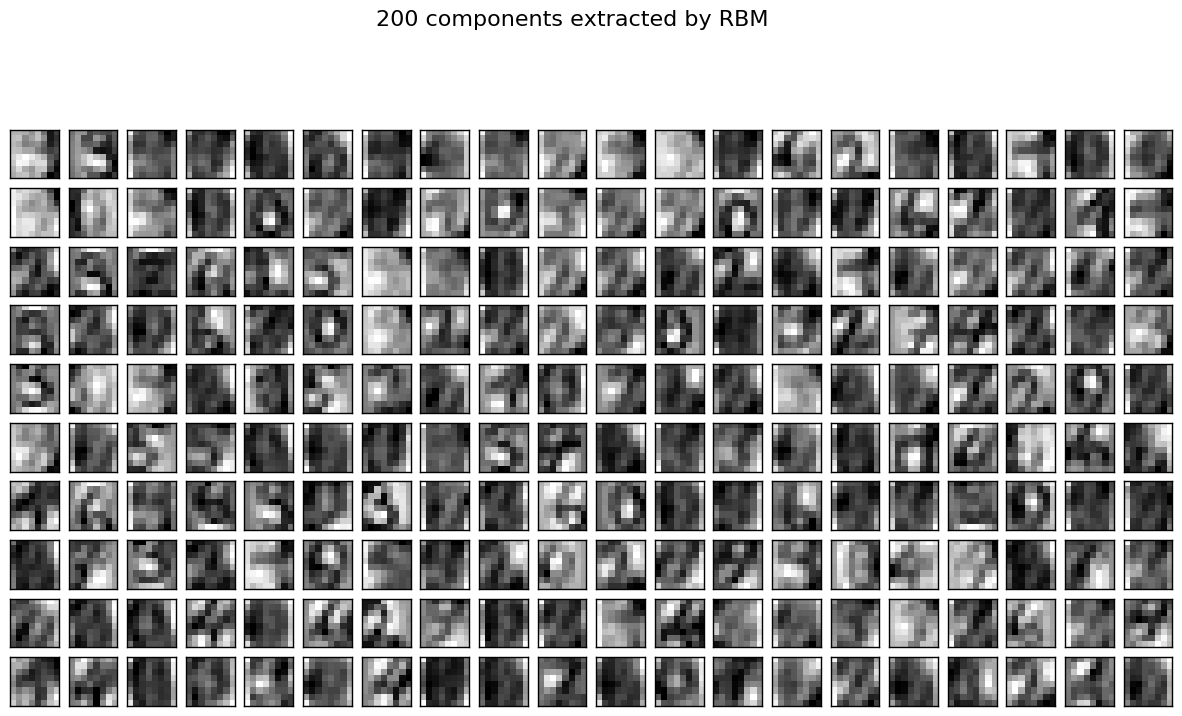

In [13]:
plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_):
    plt.subplot(20, 20, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('200 components extracted by RBM', fontsize=16)
plt.show()